In [1]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv("dataset/aug_label.csv", sep=',')
df = df.sample(frac=1).reset_index(drop=True)
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])
display(df.head(10))

,image,emotion,emotion_encoded
0,aug_9303_115.jpg,Fear,3
1,aug_6235_35.jpg,Fear,3
2,aug_7238_10.jpg,Disgust,2
3,aug_10084_123.jpg,Fear,3
4,aug_5374_132.jpg,Happy,4
5,aug_3322_63.jpg,Surprised,7
6,aug_2673_80.jpg,Anger,0
7,aug_8720_120.jpg,Anger,0
8,aug_2666_8.jpg,Anger,0
9,aug_5353_35.jpg,Fear,3


<Axes: xlabel='emotion'>

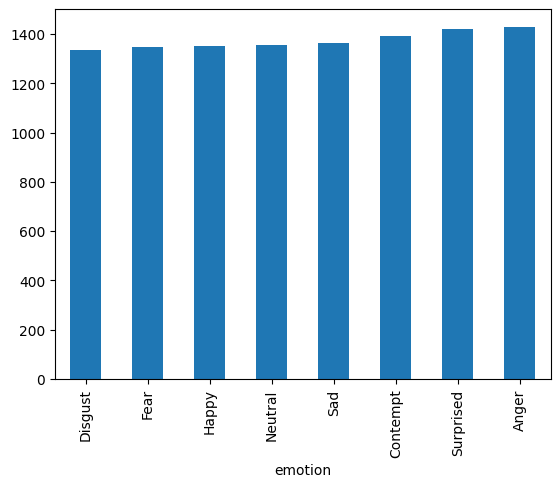

In [3]:
df.emotion.value_counts().sort_values().plot(kind = 'bar')

In [4]:
train_set, test_set = train_test_split(df,random_state=42,test_size=0.2)

In [5]:
embeddings_names = os.listdir('tensor')
name_embeddings = {}
for name in embeddings_names:
    name_embeddings[name[:-2]+'jpg'] = torch.load(os.path.join('tensor', name)).cpu()

class FullDataSet():
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        emotion = self.data.iloc[idx]['emotion_encoded']
        image_name = self.data.iloc[idx]['image']
        image_tensor = name_embeddings.get(image_name)
        image_tensor = image_tensor.permute(1,2,0)
        image_tensor_view = image_tensor.view(-1, image_tensor.size(2))
        return image_tensor_view, torch.tensor(emotion) 
    
train_data = FullDataSet(train_set)
train_loader = DataLoader(train_data, batch_size=256)

validation_data = FullDataSet(test_set)
validation_loader = DataLoader(validation_data, batch_size=64)

In [6]:
#import pickle
#pickle.dump(name_embeddings, open('resnet_aug_embeddings.pkl', 'wb'))

In [7]:
device = 'cuda'
class TransformerClassifier(nn.Module):
    def __init__(self, model_dim=512, num_heads=4, num_layers=4, num_classes=8):
        super(TransformerClassifier, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=128)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, num_classes) 

    def forward(self, x):
        x = self.transformer(x)  # (batch, 49, 512) → (batch, 49, 512)
        x = x.mean(dim=1)  # Mean Pooling
        x = self.fc(x)  # (batch, 512) → (batch, 2)
        return x
    
model = TransformerClassifier()
model.to(device)

/home/tasin/anaconda3/envs/DiT/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerClassifier(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=512, out_features=8, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train_model(epochs=20):
    highest_accuracy = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        predict_arr, gt_arr = [], []
        for images, labels in train_loader:        
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            for images, labels in validation_loader:        
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                predict_arr = predict_arr + predicted.cpu().tolist()
                gt_arr = gt_arr + labels.cpu().tolist()                    
        accuracy = accuracy_score(predict_arr, gt_arr)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy*100:.2f}%')
        
        if highest_accuracy < accuracy:
            print("Saving this model")
            torch.save(model.state_dict(), 'best.pt')
            highest_accuracy = accuracy

In [13]:
train_model()

Epoch [1/20], Loss: 2.0961628232683456, Accuracy: 12.50%
Saving this model
Epoch [2/20], Loss: 2.0945510046822684, Accuracy: 12.50%
Epoch [3/20], Loss: 2.0931862013680593, Accuracy: 12.50%
Epoch [4/20], Loss: 2.0919202872685023, Accuracy: 12.50%
Epoch [5/20], Loss: 2.090744066238403, Accuracy: 12.50%
Epoch [6/20], Loss: 2.0898873124803816, Accuracy: 12.50%
Epoch [7/20], Loss: 2.0910500390189033, Accuracy: 12.55%
Saving this model
Epoch [8/20], Loss: 2.0994670391082764, Accuracy: 12.50%
Epoch [9/20], Loss: 2.094397326878139, Accuracy: 12.50%
Epoch [10/20], Loss: 2.0898169040679933, Accuracy: 12.50%
Epoch [11/20], Loss: 2.0879147257123676, Accuracy: 12.50%
Epoch [12/20], Loss: 2.087178931917463, Accuracy: 12.50%
Epoch [13/20], Loss: 2.086454050881522, Accuracy: 12.50%
Epoch [14/20], Loss: 2.085891076496669, Accuracy: 12.50%
Epoch [15/20], Loss: 2.0853972503117153, Accuracy: 12.50%
Epoch [16/20], Loss: 2.0849908079419817, Accuracy: 12.50%
Epoch [17/20], Loss: 2.084745843069894, Accuracy: 